In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

After importing necessary packages, we set the plotter to be in paper context.
You can skip this if LaTeX is not installed in your system.

In [10]:
# You can skip this if LaTeX is not installed in your system
plotter.set_context("paper")

Then we define the function that describes the dynamic of a differential drive robot.
This description can also be found in Slide 4 of the lecture.

In [2]:
def differential_drive_dynamic(x:np.ndarray, u:np.ndarray, r:float=1., a:float=0.5)-> np.ndarray:
    """
    Unicycle dynamics.
    The state x contains (x,y,phi).
    The input u contains (theta_r_dot, theta_l_dot)

    Parameters
    ----------
    u: np.ndarray (2,)
    x: np.ndarray (3,)
    r: radius of the wheel
    a: width of the car

    Returns
    -------
    dx_dt: np.ndarray (3,)
    """

    return np.array([[0.5*r*np.cos(x[-1]),0.5*r*np.cos(x[-1])],
                     [0.5*r*np.sin(x[-1]),0.5*r*np.sin(x[-1])],
                     [r/(2*a),-r/(2*a)]])@u

After that we will generate a desired trajectory in a two-dimensional space.
So here, we will construct a desired trajectory that looks like a circle.

In [3]:
N_t = 3000 # how many samples
dt = 5e-4 # sampling time
magnitude = 5 # some random variable
t_raw = np.arange(N_t)*dt
t_span = 1.5*(1 - np.exp(-1*t_raw)) # t variable
desired_x = magnitude*np.cos(2 * np.pi * t_span) - 1
desired_y = magnitude*np.sin(2 * np.pi * t_span)
desired_xy = np.block([[desired_x], [desired_y]]).T

Then we initiate the controlled trajectory, where it will store the actual trajectory of the robot under control.
We will assign the controlled trajectory as a zero array to it.
The dimension of the controlled trajectory is N_t x 3, where N_t  is defined above

In [4]:
controlled_trajectory = np.zeros((t_span.shape[0],3))
controlled_trajectory[0] = np.array([desired_xy[0,0],desired_xy[0,1],np.pi/3])+1e-0*np.random.randn(3)

Your tasks:
* Modify the following parameters (ONLY): K_p_v, K_i_v, K_p_phi, K_i_phi, So that the controller can bring the robot to follow the desired trajectory.
* You need also to attach plots that you obtain below in your report.
* Calculate the mean squared error with the formula at the end of this notebook. Report your MSE.

In [5]:
K_p_v = 1e0
K_i_v = 1e0
K_p_phi = 1e0
K_i_phi = 1e0

max_speed_control = 60

sum_norm_e = 0
sum_e_phi = 0
u_hist = []
for i in range(t_span.shape[0]-1):
    e = desired_xy[i,:2] - controlled_trajectory[i,:2]
    norm_e = np.linalg.norm(e)
    theta_plus_dot = K_p_v*norm_e + K_i_v*sum_norm_e
    theta_plus_dot = np.minimum(theta_plus_dot,max_speed_control)
    sum_norm_e += norm_e
    phi_d = np.arctan2(e[1],e[0])

    #since phi_d can only be [0,2pi] this need to be handled properly
    if phi_d-controlled_trajectory[i,-1] < -np.pi:
        phi_d=phi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    elif phi_d-controlled_trajectory[i,-1] > np.pi:
        phi_d=phi_d-2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    else:
        phi_d = phi_d

    e_phi = (phi_d-controlled_trajectory[i,-1])
    sum_e_phi += e_phi
    theta_min_dot = K_p_phi*e_phi + K_i_phi*sum_e_phi
    theta_r_dot_ = 0.5*(theta_plus_dot+theta_min_dot)
    theta_l_dot_ = 0.5*(theta_plus_dot-theta_min_dot)
    u_ = np.array([theta_r_dot_,theta_l_dot_])
    u_hist.append(u_)
    controlled_trajectory[i+1] = ode.rk_one_step(differential_drive_dynamic,controlled_trajectory[i],dt,u_)
u_hist = np.stack(u_hist)

After that you need to verify that the controller is able to make the robot to follow the desired trajectory.
We save this plot as controlled_trajectory.png in the notebook folder.

/home/muhammad/GitHub/Rigid_Body/src/rigidbody/plotter.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = Polygon(_P[:, :2], fill=True, color=initial_color, edgecolor=initial_color)
/home/muhammad/GitHub/Rigid_Body/src/rigidbody/plotter.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = Polygon(_P[:, :2], fill=True, color=color, edgecolor=color)


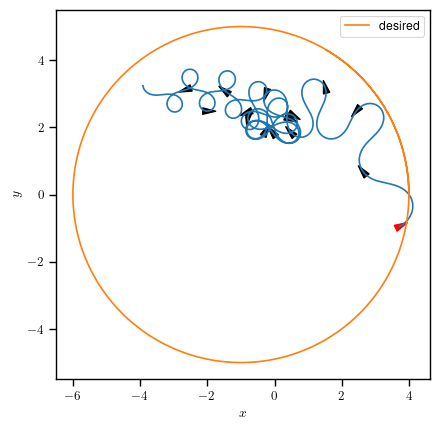

In [11]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_trajectory,0.10,200,initial_color="red")
ax.plot(desired_xy[:,0],desired_xy[:,1], label='desired')
ax.legend()
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig('controlled_trajectory.png')

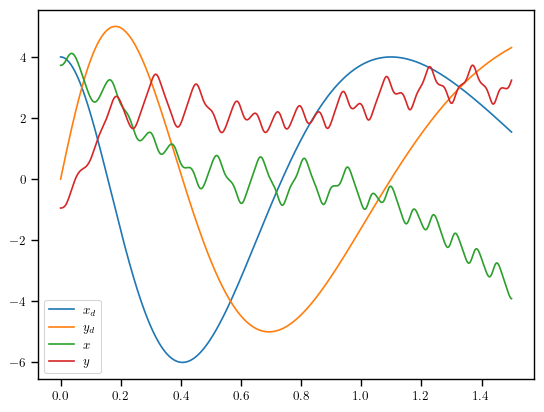

In [14]:
plt.plot(t_raw,desired_xy,label=[r'$x_d$',r'$y_d$'])
plt.plot(t_raw,controlled_trajectory[:,:2],label=[r'$x$',r'$y$'])
plt.legend()
plt.savefig('controlled_vs_desired_x_y.png')

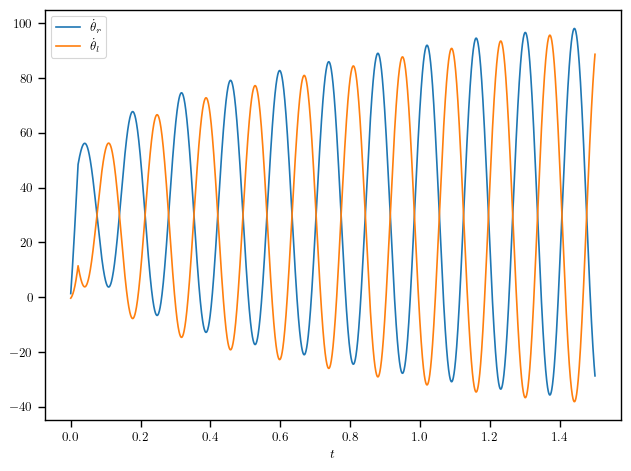

In [15]:
plt.plot(t_raw[1:],u_hist, label=[r"$\dot\theta_r$",r"$\dot\theta_l$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()
plt.savefig('theta_dots.png')

Lastly, calculate the mean squared integral error:

In [20]:
xy_error = desired_xy-controlled_trajectory[:,:2]
mse = np.square(np.linalg.norm(xy_error,axis=1)).mean()

In [21]:
mse

34.634843056234345